<a href="https://colab.research.google.com/github/SKG08/Telco-Customer-Churn-Prediction-using-XGBoost/blob/main/Customer_Churn_Analysis_using_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries

In [1]:

import pandas as pd
import numpy as np
import  xgboost as xgb
from sklearn.model_selection  import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import GridSearchCV

## Import Dataset
The data is IBM Telco Customer Churn data

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Telco_customer_churn.xlsx to Telco_customer_churn.xlsx


In [3]:
import io
df = pd.read_excel(io.BytesIO(uploaded['Telco_customer_churn.xlsx']))
df.head()

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,Yes,1,89,5340,Competitor had better devices


In [ ]:
df.columns

Index(['CustomerID', 'Count', 'Country', 'State', 'City', 'Zip Code',
       'Lat Long', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen',
       'Partner', 'Dependents', 'Tenure Months', 'Phone Service',
       'Multiple Lines', 'Internet Service', 'Online Security',
       'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV',
       'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method',
       'Monthly Charges', 'Total Charges', 'Churn Label', 'Churn Value',
       'Churn Score', 'CLTV', 'Churn Reason'],
      dtype='object')

In [ ]:
df['Country'].unique()

array(['United States'], dtype=object)

In [ ]:
df['City'].unique()

array(['Los Angeles', 'Beverly Hills', 'Huntington Park', ..., 'Standish',
       'Tulelake', 'Olympic Valley'], dtype=object)

In [ ]:
df['State'].unique()

array(['California'], dtype=object)

## Dropping unneccessary columns

*   Customer Id, Count, Zip Code, Lat Long, Latitude and Longitude are not usefule for model development.
*   Country and State have only single value  
*   Last 4 columns contains information on exit interview and not neccesary for  model training.

In [4]:
df.drop(['CustomerID','Count','Country', 'State','Zip Code','Lat Long','Churn Label','Churn Score', 'CLTV', 'Churn Reason'],axis=1,inplace=True)
df.columns

Index(['City', 'Latitude', 'Longitude', 'Gender', 'Senior Citizen', 'Partner',
       'Dependents', 'Tenure Months', 'Phone Service', 'Multiple Lines',
       'Internet Service', 'Online Security', 'Online Backup',
       'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies',
       'Contract', 'Paperless Billing', 'Payment Method', 'Monthly Charges',
       'Total Charges', 'Churn Value'],
      dtype='object')

## Replacing white space in city values

In [5]:
df['City'].replace(" ","_",regex=True,inplace=True)
df.head()

,City,Latitude,Longitude,Gender,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Multiple Lines,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Streaming TV,Streaming Movies,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Value
0,Los_Angeles,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,1
1,Los_Angeles,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,1
2,Los_Angeles,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,1
3,Los_Angeles,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,1
4,Los_Angeles,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,1


In [6]:
df['City'].unique()[0:10]

array(['Los_Angeles', 'Beverly_Hills', 'Huntington_Park', 'Lynwood',
       'Marina_Del_Rey', 'Inglewood', 'Santa_Monica', 'Torrance',
       'Whittier', 'La_Habra'], dtype=object)

## Replacing white space in column names

In [7]:
df.columns = df.columns.str.replace(" ","_")
df.columns

Index(['City', 'Latitude', 'Longitude', 'Gender', 'Senior_Citizen', 'Partner',
       'Dependents', 'Tenure_Months', 'Phone_Service', 'Multiple_Lines',
       'Internet_Service', 'Online_Security', 'Online_Backup',
       'Device_Protection', 'Tech_Support', 'Streaming_TV', 'Streaming_Movies',
       'Contract', 'Paperless_Billing', 'Payment_Method', 'Monthly_Charges',
       'Total_Charges', 'Churn_Value'],
      dtype='object')

## Missing Value Analysis

In [ ]:
df.dtypes

City                  object
Latitude             float64
Longitude            float64
Gender                object
Senior_Citizen        object
Partner               object
Dependents            object
Tenure_Months          int64
Phone_Service         object
Multiple_Lines        object
Internet_Service      object
Online_Security       object
Online_Backup         object
Device_Protection     object
Tech_Support          object
Streaming_TV          object
Streaming_Movies      object
Contract              object
Paperless_Billing     object
Payment_Method        object
Monthly_Charges      float64
Total_Charges         object
Churn_Value            int64
dtype: object

In [ ]:
missing_data = df.isnull()
for col in missing_data.columns.to_list():
  print(col)
  print(missing_data[col].value_counts())
  print("")

There is no miising data though Total_Charges column supposed to be numeric and data type shoild be float/integer but it is object so we should check further.

In [8]:
print(len(df.loc[(df['Total_Charges']==" ")]))
df.loc[(df['Total_Charges']==" ")]

11


,City,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
2234,San_Bernardino,34.084909,-117.258107,Female,No,Yes,No,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,0
2438,Independence,36.869584,-118.189241,Male,No,No,No,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,0
2568,San_Mateo,37.590421,-122.306467,Female,No,Yes,No,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,,0
2667,Cupertino,37.306612,-122.080621,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,0
2856,Redcrest,40.363446,-123.835041,Female,No,Yes,No,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,0
4331,Los_Angeles,34.089953,-118.294824,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,0
4687,Sun_City,33.739412,-117.173334,Male,No,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,0
5104,Ben_Lomond,37.078873,-122.090386,Female,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,0
5719,La_Verne,34.144703,-117.770299,Male,No,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,0
6772,Bell,33.970343,-118.171368,Female,No,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,,0


There are 11 observations where Total Charges are miising/blank values and Tenure in months is also zero for all these cases. We need to replace these values with zeros.

In [9]:
df.loc[(df["Total_Charges"] == " "), "Total_Charges"] = 0

In [10]:
print(len(df.loc[(df['Total_Charges']==" ")]))

0


## Converting Total Charges column from string to numeric

In [11]:
df['Total_Charges'] = pd.to_numeric(df["Total_Charges"])
df['Total_Charges'].dtypes

dtype('float64')

## Replacing all white spaces in all colums with underscore ("_")

In [12]:
df.replace(" ","_",regex=True,inplace=True)
df.head()

,City,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Value
0,Los_Angeles,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,1
1,Los_Angeles,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,1
2,Los_Angeles,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber_optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50,1
3,Los_Angeles,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber_optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05,1
4,Los_Angeles,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber_optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30,1


## Split data in Target Variabled and Features 

In [13]:
X = df.drop('Churn_Value', axis=1).copy()
X.head()

,City,Latitude,Longitude,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges
0,Los_Angeles,33.964131,-118.272783,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15
1,Los_Angeles,34.059281,-118.307420,Female,No,No,Yes,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65
2,Los_Angeles,34.048013,-118.293953,Female,No,No,Yes,8,Yes,Yes,Fiber_optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic_check,99.65,820.50
3,Los_Angeles,34.062125,-118.315709,Female,No,Yes,Yes,28,Yes,Yes,Fiber_optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic_check,104.80,3046.05
4,Los_Angeles,34.039224,-118.266293,Male,No,No,Yes,49,Yes,Yes,Fiber_optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank_transfer_(automatic),103.70,5036.30


In [14]:
y = df['Churn_Value'].copy()
y.head()

0    1
1    1
2    1
3    1
4    1
Name: Churn_Value, dtype: int64

## One HOT Encoding of Categorical Variables

In [15]:
X_encoded = pd.get_dummies(X,columns=['City', 
                                      'Gender', 
                                      'Senior_Citizen', 
                                      'Partner',
                                      'Dependents',
                                      'Phone_Service',
                                      'Multiple_Lines',
                                      'Internet_Service',
                                      'Online_Security',
                                      'Online_Backup',
                                      'Device_Protection',
                                      'Tech_Support',
                                      'Streaming_TV',
                                      'Streaming_Movies',
                                      'Contract',
                                      'Paperless_Billing',
                                      'Payment_Method',],
                           )
X_encoded.head()

,Latitude,Longitude,Tenure_Months,Monthly_Charges,Total_Charges,City_Acampo,City_Acton,City_Adelanto,City_Adin,City_Agoura_Hills,City_Aguanga,City_Ahwahnee,City_Alameda,City_Alamo,City_Albany,City_Albion,City_Alderpoint,City_Alhambra,City_Aliso_Viejo,City_Alleghany,City_Alpaugh,City_Alpine,City_Alta,City_Altadena,City_Alturas,City_Alviso,City_Amador_City,City_Amboy,City_Anaheim,City_Anderson,City_Angels_Camp,City_Angelus_Oaks,City_Angwin,City_Annapolis,City_Antelope,City_Antioch,City_Anza,City_Apple_Valley,City_Applegate,City_Aptos,...,Senior_Citizen_Yes,Partner_No,Partner_Yes,Dependents_No,Dependents_Yes,Phone_Service_No,Phone_Service_Yes,Multiple_Lines_No,Multiple_Lines_No_phone_service,Multiple_Lines_Yes,Internet_Service_DSL,Internet_Service_Fiber_optic,Internet_Service_No,Online_Security_No,Online_Security_No_internet_service,Online_Security_Yes,Online_Backup_No,Online_Backup_No_internet_service,Online_Backup_Yes,Device_Protection_No,Device_Protection_No_internet_service,Device_Protection_Yes,Tech_Support_No,Tech_Support_No_internet_service,Tech_Support_Yes,Streaming_TV_No,Streaming_TV_No_internet_service,Streaming_TV_Yes,Streaming_Movies_No,Streaming_Movies_No_internet_service,Streaming_Movies_Yes,Contract_Month-to-month,Contract_One_year,Contract_Two_year,Paperless_Billing_No,Paperless_Billing_Yes,Payment_Method_Bank_transfer_(automatic),Payment_Method_Credit_card_(automatic),Payment_Method_Electronic_check,Payment_Method_Mailed_check
0,33.964131,-118.272783,2,53.85,108.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1
1,34.059281,-118.307420,2,70.70,151.65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,1,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0
2,34.048013,-118.293953,8,99.65,820.50,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
3,34.062125,-118.315709,28,104.80,3046.05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,1,0,1,0,0,1,0,1,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0,0,1,0
4,34.039224,-118.266293,49,103.70,5036.30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,1,0,0,1,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,1,1,0,0,0


## Train Test Split

In [ ]:
y.sum()/len(y)

0.2653698707936959

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y,random_state=42,stratify=y)
print(y_train.sum()/len(y_train))
print(y_test.sum()/len(y_test))
print(X_train.shape)
print(X_test.shape)

0.2654297614539947
0.26519023282226006
(5282, 1177)
(1761, 1177)


## Primary Model Development

In [18]:
xgb_model = xgb.XGBClassifier(objective='binary:logistic',missing=None,seed=42)
xgb_model.fit(X_train,
              y_train,
              verbose=True,
              early_stopping_rounds=10,
              eval_metric='aucpr',
              eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.578392
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.580597
[2]	validation_0-aucpr:0.590099
[3]	validation_0-aucpr:0.601636
[4]	validation_0-aucpr:0.608932
[5]	validation_0-aucpr:0.603647
[6]	validation_0-aucpr:0.616851
[7]	validation_0-aucpr:0.610948
[8]	validation_0-aucpr:0.620241
[9]	validation_0-aucpr:0.624769
[10]	validation_0-aucpr:0.627795
[11]	validation_0-aucpr:0.627932
[12]	validation_0-aucpr:0.644946
[13]	validation_0-aucpr:0.647473
[14]	validation_0-aucpr:0.651648
[15]	validation_0-aucpr:0.6508
[16]	validation_0-aucpr:0.650832
[17]	validation_0-aucpr:0.65056
[18]	validation_0-aucpr:0.649701
[19]	validation_0-aucpr:0.650672
[20]	validation_0-aucpr:0.65075
[21]	validation_0-aucpr:0.650874
[22]	validation_0-aucpr:0.65194
[23]	validation_0-aucpr:0.65307
[24]	validation_0-aucpr:0.652502
[25]	validation_0-aucpr:0.652446
[26]	validation_0-aucpr:0.655478
[27]	validation_0-aucpr:0.654618
[28]	validation_0-aucpr:0.

XGBClassifier(seed=42)

## Plot Confusion Matrix

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


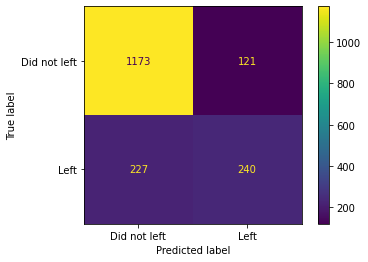

In [19]:
plot_confusion_matrix(xgb_model, X_test,y_test,values_format='d',display_labels=["Did not left","Left"])

## Parameter optimization using Gridsearch 

In [ ]:
params = {'max_depth':[3,4,5],
          'learning_rate':[0.1,0.01,0.05],
          'gamma':[0.1,0.25,0.5,1.0],
          'reg_lambda':[0,1.0,10.0],
          'scale_pos_weight':[1,3,5]}


In [ ]:
xgb_grid = GridSearchCV(estimator= xgb.XGBClassifier(objective='binary:logistic',seed=42,subsample=0.9, colsample_bytree=0.5),
                        param_grid = params,
                        scoring='roc_auc',
                        cv=3, 
                        n_jobs= 10,
                        verbose = 2)
xgb_grid.fit(X_train,
             y_train,
             early_stopping_rounds=10,
             eval_metric='auc',
             eval_set=[(X_test,y_test)],
             verbose= False)

## Final Model

In [20]:
xgb_model_final = xgb.XGBClassifier(objective='binary:logistic',
                                    seed=42,
                                    gamma=0.25,
                                    learn_rate = 0.1,
                                    max_depth=4,
                                    reg_lambda=10,
                                    scale_pos_weight=3,                                    
                                    subsample=0.9, 
                                    colsample_bytree=0.5)
xgb_model_final.fit(X_train,
             y_train,
             verbose=True,
             early_stopping_rounds=10,
             eval_metric='aucpr',
             eval_set=[(X_test,y_test)])

[0]	validation_0-aucpr:0.554742
Will train until validation_0-aucpr hasn't improved in 10 rounds.
[1]	validation_0-aucpr:0.56892
[2]	validation_0-aucpr:0.615286
[3]	validation_0-aucpr:0.618233
[4]	validation_0-aucpr:0.624016
[5]	validation_0-aucpr:0.631781
[6]	validation_0-aucpr:0.633163
[7]	validation_0-aucpr:0.635934
[8]	validation_0-aucpr:0.635909
[9]	validation_0-aucpr:0.637043
[10]	validation_0-aucpr:0.640735
[11]	validation_0-aucpr:0.641192
[12]	validation_0-aucpr:0.641457
[13]	validation_0-aucpr:0.641542
[14]	validation_0-aucpr:0.640467
[15]	validation_0-aucpr:0.645639
[16]	validation_0-aucpr:0.645757
[17]	validation_0-aucpr:0.645102
[18]	validation_0-aucpr:0.644465
[19]	validation_0-aucpr:0.642745
[20]	validation_0-aucpr:0.646759
[21]	validation_0-aucpr:0.648365
[22]	validation_0-aucpr:0.654176
[23]	validation_0-aucpr:0.6551
[24]	validation_0-aucpr:0.657394
[25]	validation_0-aucpr:0.653484
[26]	validation_0-aucpr:0.655869
[27]	validation_0-aucpr:0.658989
[28]	validation_0-aucpr

XGBClassifier(colsample_bytree=0.5, gamma=0.25, learn_rate=0.1, max_depth=4,
              reg_lambda=10, scale_pos_weight=3, seed=42, subsample=0.9)

## Plot Confusion Matrix


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


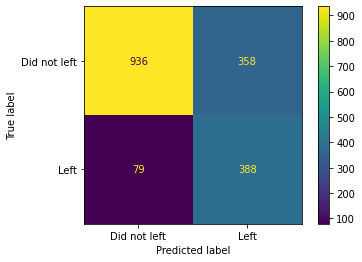

In [21]:
plot_confusion_matrix(xgb_model_final,
                      X_test,
                      y_test,
                      values_format='d',
                      display_labels=["Did not left","Left"])

## Plotting the tree
Build the first tree to avoid average of all the trees

In [22]:
# Build the first tree to avoid average of all the trees
xgb_model_tree_plot = xgb.XGBClassifier(objective='binary:logistic',
                                    seed=42,
                                    gamma=0.25,
                                    learn_rate = 0.1,
                                    max_depth=4,
                                    reg_lambda=10,
                                    scale_pos_weight=3,                                    
                                    subsample=0.9, 
                                    colsample_bytree=0.5,
                                    n_estimators=1)
xgb_model_tree_plot.fit(X_train, y_train)
            

XGBClassifier(colsample_bytree=0.5, gamma=0.25, learn_rate=0.1, max_depth=4,
              n_estimators=1, reg_lambda=10, scale_pos_weight=3, seed=42,
              subsample=0.9)

In [23]:
bst = xgb_model_tree_plot.get_booster()
for type in ('weight','gain','cover','total_gain','total_cover'):
  print("%s: " % type, bst.get_score(importance_type = type))

weight:  {'Contract_Month-to-month': 1, 'Dependents_No': 2, 'Contract_One_year': 1, 'City_San_Bernardino': 1, 'Streaming_TV_Yes': 1, 'Tenure_Months': 3, 'Payment_Method_Mailed_check': 1, 'Partner_Yes': 1, 'Online_Backup_No_internet_service': 1}
gain:  {'Contract_Month-to-month': 1631.77637, 'Dependents_No': 181.70684795, 'Contract_One_year': 59.6826782, 'City_San_Bernardino': 11.035614, 'Streaming_TV_Yes': 55.2778931, 'Tenure_Months': 59.412152633333335, 'Payment_Method_Mailed_check': 9.28771687, 'Partner_Yes': 22.5820084, 'Online_Backup_No_internet_service': 158.669495}
cover:  {'Contract_Month-to-month': 1820.25, 'Dependents_No': 910.125, 'Contract_One_year': 444.5, 'City_San_Bernardino': 196.75, 'Streaming_TV_Yes': 247.75, 'Tenure_Months': 403.5833333333333, 'Payment_Method_Mailed_check': 49.75, 'Partner_Yes': 93.5, 'Online_Backup_No_internet_service': 1067.5}
total_gain:  {'Contract_Month-to-month': 1631.77637, 'Dependents_No': 363.4136959, 'Contract_One_year': 59.6826782, 'City_Sa

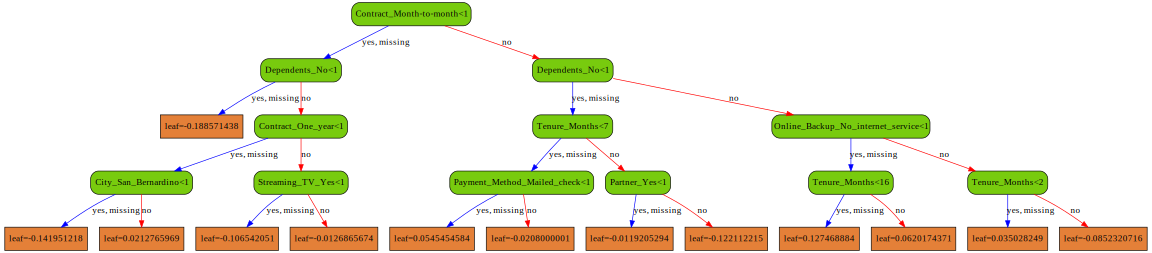

In [30]:
node_params = {'shape': 'box',
               'style':'filled,rounded',
               'fillcolor':"#78cbe"}

leaf_params = {'shape': 'box',
               'style':'filled',
               'fillcolor':"#e48038"}

xgb.to_graphviz(xgb_model_tree_plot, num_trees=0, size='16,9',
                condition_node_params=node_params,
                leaf_node_params=leaf_params)